In [1]:
import pickle
import numpy as np
from tqdm.notebook import trange, tqdm
import json
from sklearn.metrics import roc_curve, auc
from features import get_transformer, merge_entries
from utills import chunker, get_num_chunks, cartesian_product
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.tag.perceptron import PerceptronTagger

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
DATA_DIR = 'data/pan/'
GROUND_TRUTH_PATH = DATA_DIR + 'pan20-authorship-verification-training-large-truth.jsonl'
PREPROCESSED_DATA_PATH = '/scratch/jnw301/av_public/temp_data/pan/'
# TEMP_DATA_PATH = 'temp_data/pan/'
TEMP_DATA_PATH = '/scratch/jnw301/av_public/temp_data/pan/split_models/'

In [4]:
ground_truth = {}
with open(GROUND_TRUTH_PATH, 'r') as f:
    for l in f:
        d = json.loads(l)
        ground_truth[d['id']] = d['same']

In [18]:
# x_path_1 = TEMP_DATA_PATH + 'pos_token_ids_1_train.npy'
# x_path_2 = TEMP_DATA_PATH + 'pos_token_ids_2_train.npy'
# preprocessed_path = PREPROCESSED_DATA_PATH + 'preprocessed_train.jsonl'
# ordered_idxs = train_idxs
# tag_2_idx = tag_2_idx
# vector_sz = train_sz
# chunk_sz=5

# author_bounds = {}
# total_recs = 0
# with open(preprocessed_path, 'r') as f:
#     for l in tqdm(f, total=vector_sz):
#         d = json.loads(l)
#         n_doc1_chunks = get_num_chunks(d['pair'][0], chunk_sz)
#         n_doc2_chunks = get_num_chunks(d['pair'][1], chunk_sz)
        
#         author_bounds[d['id'] + '_1'] = (total_recs, total_recs + n_doc1_chunks)
#         total_recs += n_doc1_chunks
        
#         author_bounds[d['id'] + '_2'] = (total_recs, total_recs + n_doc2_chunks)
#         total_recs += n_doc2_chunks
# max_seq_len

  0%|          | 0/193536 [00:00<?, ?it/s]

In [25]:
# max_seq_len = 650
# pos_token_ids = np.memmap(x_path_1, dtype='int32', mode='w+', shape=(total_recs, max_seq_len))

# with open(preprocessed_path, 'r') as f:
#     for l in tqdm(f, total=vector_sz):
#         d = json.loads(l)

#         s, e = author_bounds[d['id'] + '_1']
#         docs_merged_1 = [merge_entries(c) for c in list(chunker(d['pair'][0], chunk_sz))]
#         for i in range(len(docs_merged_1)):
#             doc = docs_merged_1[i]
#             for j, tag in enumerate(doc['pos_tags'][:max_seq_len]):
#                 pos_token_ids[s + i, j] = tag_2_idx[tag]
        
#         s, e = author_bounds[d['id'] + '_2']
#         docs_merged_2 = [merge_entries(c) for c in list(chunker(d['pair'][1], chunk_sz))]
#         for i in range(len(docs_merged_2)):
#             doc = docs_merged_2[i]
#             for j, tag in enumerate(doc['pos_tags'][:max_seq_len]):
#                 pos_token_ids[s + i, j] = tag_2_idx[tag]

  0%|          | 0/193536 [00:00<?, ?it/s]

In [ ]:
# with open(TEMP_DATA_PATH + 'experiment_data_5.p', 'rb') as f:
#     (
#             aucs,
#             clf,
#             roc_auc,
#             transformer, 
#             scaler,
#             secondary_scaler,
#             feature_sz,
#             train_sz,
#             train_idxs,
#             test_sz,
#             test_idxs
#     ) = pickle.load(f)

In [5]:
tagger = PerceptronTagger()
tagset = list(tagger.classes)
tag_2_idx = {t:i for i, t in enumerate(tagset)}
idx_2_tag = {i:t for i, t in enumerate(tagset)}


In [6]:
def encode_pos_tags(x_path, preprocessed_path, tag_2_idx, vector_sz, chunk_sz, max_seq_len):
    
    author_bounds = {}
    total_recs = 0
    i = 0
    with open(preprocessed_path, 'r') as f:
        for l in tqdm(f, total=vector_sz):
            d = json.loads(l)
            n_doc1_chunks = get_num_chunks(d['pair'][0], chunk_sz)
            n_doc2_chunks = get_num_chunks(d['pair'][1], chunk_sz)

            author_bounds[d['id'] + '_1'] = (total_recs, total_recs + n_doc1_chunks)
            total_recs += n_doc1_chunks

            author_bounds[d['id'] + '_2'] = (total_recs, total_recs + n_doc2_chunks)
            total_recs += n_doc2_chunks
            i += 1
#             if i > 1000:
#                 break
            
    pos_token_ids = np.memmap(x_path, dtype='int32', mode='w+', shape=(total_recs, max_seq_len))
    count = 0
    with open(preprocessed_path, 'r') as f:
        for l in tqdm(f, total=vector_sz):
            d = json.loads(l)

            s, e = author_bounds[d['id'] + '_1']
            docs_merged_1 = [merge_entries(c) for c in list(chunker(d['pair'][0], chunk_sz))]
            for i in range(len(docs_merged_1)):
                doc = docs_merged_1[i]
                for j, tag in enumerate(doc['pos_tags'][:max_seq_len]):
                    pos_token_ids[s + i, j] = tag_2_idx[tag]

            s, e = author_bounds[d['id'] + '_2']
            docs_merged_2 = [merge_entries(c) for c in list(chunker(d['pair'][1], chunk_sz))]
            for i in range(len(docs_merged_2)):
                doc = docs_merged_2[i]
                for j, tag in enumerate(doc['pos_tags'][:max_seq_len]):
                    pos_token_ids[s + i, j] = tag_2_idx[tag]
            count +=1 
#             if count > 1000:
#                 break
    return pos_token_ids, author_bounds, total_recs

In [8]:
# max_seq_length = 650
# chunk_sz = 5

# pos_train, author_bounds_train, total_recs_train = encode_pos_tags(
#     TEMP_DATA_PATH + 'pos_token_ids_train.npy',
#     PREPROCESSED_DATA_PATH + 'preprocessed_train.jsonl',
#     tag_2_idx,
#     train_sz,
#     chunk_sz,
#     max_seq_length
# )

# pos_test, author_bounds_test, total_recs_test = encode_pos_tags(
#     TEMP_DATA_PATH + 'pos_token_ids_test.npy',
#     PREPROCESSED_DATA_PATH + 'preprocessed_test.jsonl',
#     tag_2_idx,
#     test_sz,
#     chunk_sz,
#     max_seq_length
# )

# with open(TEMP_DATA_PATH + 'lstm_experiment_data.p', 'wb') as f:
#     pickle.dump((author_bounds_train, total_recs_train, author_bounds_test, total_recs_test, chunk_sz, max_seq_length), f)
    

  0%|          | 0/193536 [00:00<?, ?it/s]

  0%|          | 0/193536 [00:00<?, ?it/s]

  0%|          | 0/81963 [00:00<?, ?it/s]

  0%|          | 0/81963 [00:00<?, ?it/s]

In [7]:
with open(TEMP_DATA_PATH + 'lstm_experiment_data.p', 'rb') as f:
    (author_bounds_train, total_recs_train, author_bounds_test, total_recs_test, chunk_sz, max_seq_length) = pickle.load(f)

In [8]:
train_ids = list(set([k[:-2] for k in author_bounds_train.keys()]))
test_ids = list(set([k[:-2] for k in author_bounds_test.keys()]))

In [9]:
class PANDChunkedataset(torch.utils.data.Dataset):
    def __init__(self, x_path, author_bounds,  ground_truth, dataset_ids, total_recs, max_seq_len, max_records=None):
        self.XX = np.memmap(x_path, dtype='int32', mode='r', shape=(total_recs, max_seq_len))

        self.X_idxs = []
        self.Y = []

        i = 0
        for d_id in dataset_ids:
            s_1, e_1 = author_bounds[d_id + '_1']
            s_2, e_2 = author_bounds[d_id + '_2']
            label = ground_truth[d_id]
            idxs = cartesian_product(range(s_1, e_1), range(s_2, e_2))
            self.X_idxs.extend(idxs)
            self.Y.extend([label] * len(idxs))

        self.X_idxs = np.array(self.X_idxs)
        self.Y = np.array(self.Y).astype(int)
        p = np.random.permutation(len(self.Y))
        self.X_idxs = self.X_idxs[p]
        self.Y = self.Y[p]
        if max_records:
            self.X_idxs = self.X_idxs[:max_records]
            self.Y = self.Y[:max_records]
        
    def __getitem__(self, index):
        i, j = self.X_idxs[index]

        return np.array(self.XX[i]), np.array(self.XX[j]), self.Y[index].astype('float32')

    def __len__(self):
        return len(self.Y)

In [10]:
train = PANDChunkedataset(TEMP_DATA_PATH + 'pos_token_ids_train.npy', author_bounds_train, ground_truth, train_ids, total_recs_train, max_seq_length, max_records=500000)
# train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False, sampler= torch.utils.data.SubsetRandomSampler(
#         torch.randint(high=len(train), size=(500000,))
#     ))
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False)

test = PANDChunkedataset(TEMP_DATA_PATH + 'pos_token_ids_test.npy', author_bounds_test, ground_truth, test_ids, total_recs_test, max_seq_length, max_records=50000)
# test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, sampler= torch.utils.data.SubsetRandomSampler(
#         torch.randint(high=len(test), size=(10000,))
#     ))
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)

In [11]:
class AV_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(
                        embedding_dim,
                        hidden_dim,
                        num_layers=n_layers,
                        bidirectional=True,
#                         dropout = dropout,
                        batch_first = True
                    )
        self.fc_1 = nn.Linear(hidden_dim * 2, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.fc = nn.Linear(output_dim, 1)
    
    def forward_once(self, x):
        x = model.embedding(x)
        packed_output,(hidden_state,cell_state) = model.lstm(x)
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        output = self.fc_1(hidden)
        return output
    
    def forward(self, x1, x2):
        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)
        x = self.bn(torch.abs(x1 - x2))
        
        x = torch.sigmoid(self.fc(x))
        
        return x

In [ ]:
model = AV_Model(len(tag_2_idx), 256, 128, 1, 32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#initialize empty list to track batch losses
train_losses = []
validation_losses = []
aucs = []
model.to(device)

for epoch in range(40):
    model.train()
    train_loss = 0.0
    for x1, x2, y in tqdm(train_loader):
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y = y.reshape(-1, 1)
        optimizer.zero_grad()
        
        out = model(x1, x2)
        loss = criterion(out, y)
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    
    preds = []
    labels = []
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        y = y.reshape(-1, 1)
        out = model(x1, x2)
        loss = criterion(out, y)
        valid_loss += loss.item()
        
        out = out.reshape(-1).tolist()
        y = y.reshape(-1).tolist()
        preds.extend(out)
        labels.extend(y)
    fpr, tpr, thresh = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    train_losses.append(train_loss / len(train_loader))
    validation_losses.append(valid_loss / len(test_loader))
    print(f'Epoch {epoch+1} \t Training Loss: {train_loss / len(train_loader)} \t Validation Loss: {valid_loss / len(test_loader)} \t AUC: {roc_auc}')
    torch.save(model, TEMP_DATA_PATH + 'pytorch_model.pt')

cuda


  0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 1 	 Training Loss: 0.6918445828475767 	 Validation Loss: 0.6876330002189597 	 AUC: 0.553189746006158


  0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 2 	 Training Loss: 0.6853539934464091 	 Validation Loss: 0.6858158778504032 	 AUC: 0.5629438033259789


  0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 3 	 Training Loss: 0.6840098040762744 	 Validation Loss: 0.6854778725625305 	 AUC: 0.5647725937552923


  0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 4 	 Training Loss: 0.6833014689089317 	 Validation Loss: 0.6852684507284628 	 AUC: 0.5660100726824894


  0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 5 	 Training Loss: 0.6827322980986199 	 Validation Loss: 0.6851930685360413 	 AUC: 0.5665930262717777


  0%|          | 0/7813 [00:00<?, ?it/s]

Epoch 6 	 Training Loss: 0.6822056622247636 	 Validation Loss: 0.6851655348487522 	 AUC: 0.566735566471798


  0%|          | 0/7813 [00:00<?, ?it/s]

In [16]:
model(x1, x2)

tensor([[0.2846],
        [0.7243],
        [0.5384],
        [0.4455],
        [0.1313],
        [0.6846],
        [0.3656],
        [0.3979],
        [0.6002],
        [0.3653],
        [0.3865],
        [0.5847],
        [0.6461],
        [0.4647],
        [0.5405],
        [0.3456],
        [0.6744],
        [0.6547],
        [0.5113],
        [0.5158],
        [0.6351],
        [0.6446],
        [0.5817],
        [0.1201],
        [0.4725],
        [0.2916],
        [0.4091],
        [0.5745],
        [0.5372],
        [0.4536],
        [0.5118],
        [0.6821],
        [0.6822],
        [0.6144],
        [0.4119],
        [0.5176],
        [0.6836],
        [0.5931],
        [0.5423],
        [0.6001],
        [0.5787],
        [0.7155],
        [0.5567],
        [0.6305],
        [0.6547],
        [0.4369],
        [0.4517],
        [0.5584],
        [0.6661],
        [0.5751],
        [0.4505],
        [0.3133],
        [0.6708],
        [0.4430],
        [0.4529],
        [0

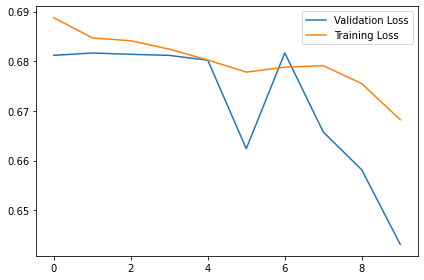

In [18]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.001, model = AV_Model(len(tag_2_idx), 32, 16, 2, 8), max_length=500

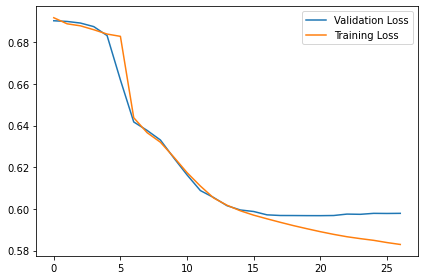

In [23]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.001, model = AV_Model(len(tag_2_idx), 32, 16, 1, 8), max_length=500

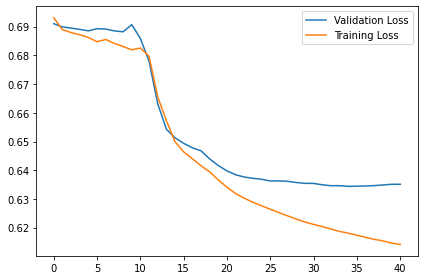

In [18]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.001, model = AV_Model(len(tag_2_idx), 32, 16, 1, 8)

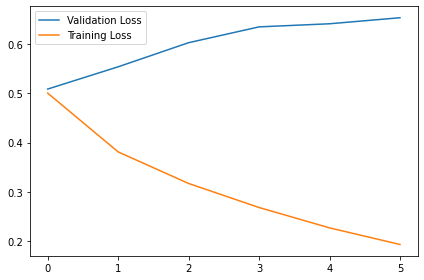

In [21]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.0001


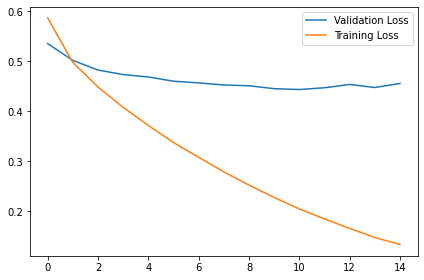

In [15]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.00001


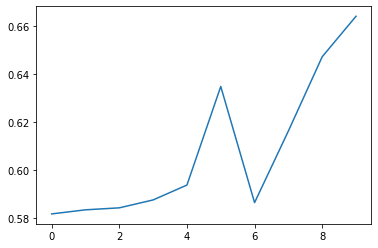

In [19]:
plt.plot(aucs)
plt.show()
# LR = 0.00001

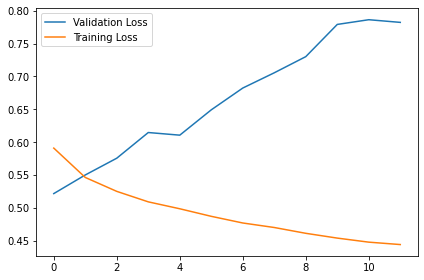

In [11]:
plt.plot(validation_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
# LR = 0.001


In [14]:
model.eval()
preds = []
labels = []
for x1, x2, y in test_loader:
    x1, x2, y = x1.to(device), x2.to(device), y.to(device)
    out = model(x1, x2).reshape(-1).tolist()
    y = y.reshape(-1).tolist()
    preds.extend(out)
    labels.extend(y)

KeyboardInterrupt: 

In [15]:
fpr, tpr, thresh = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.5699832892033204


In [33]:
torch.save(model, TEMP_DATA_PATH + 'pytorch_model.pt')